# Identify Clusters in the Chromatin Configuration

Using [`wlcstat`](https://github.com/ajspakow/wlcstat) and linker lengths obtained from our sliding nucleosome model, we generate 3D configurations for nucleosomes in our array. Based on these coordinates, we identify clusters in our configuration and characterize the radius of gyration of those clusters.

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
from itertools import groupby
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sliding_nucleosome.nucleo_arr as nuc
from wlcstat.chromo import gen_chromo_conf

#### Specify Output File

In [3]:
out_dir = "/Users/jwakim/Documents/Wakim_Research/sliding_nucleosome/output/from_sherlock/sim_146"
snap_path = f"{out_dir}/snap_0.json"

#### Load the Snapshot

In [4]:
# Load the nucleosome array snapshots
nuc_arr = nuc.NucleosomeArray.load(snap_path)

#### Generate configuration

Apply [`wlcstat`](https://github.com/ajspakow/wlcstat) chain growth algorithm to generate 3D coordinates for the nucleosome array based on the linker lengths.

In [5]:
_, _, _, r_nucleo, _ = gen_chromo_conf(nuc_arr.linker_lengths)

In [6]:
print(f"Shape of Nucleosome Coordinates Array: {r_nucleo.shape}\n")
print(r_nucleo)

Shape of Nucleosome Coordinates Array: (501, 3)

[[ 4.19000000e+00  2.07033396e+00  1.78165776e-01]
 [ 1.91468679e+00  5.61375238e+00  2.14570244e+00]
 [ 3.22237216e-01  4.99878461e+00 -5.74279268e+00]
 ...
 [-2.34674132e+02 -3.70423316e+02  3.76844474e+01]
 [-2.29003410e+02 -3.77845632e+02  4.18290885e+01]
 [-2.31326729e+02 -3.69676979e+02  4.18797301e+01]]


#### Generate a Rough Visualization of the Configuration

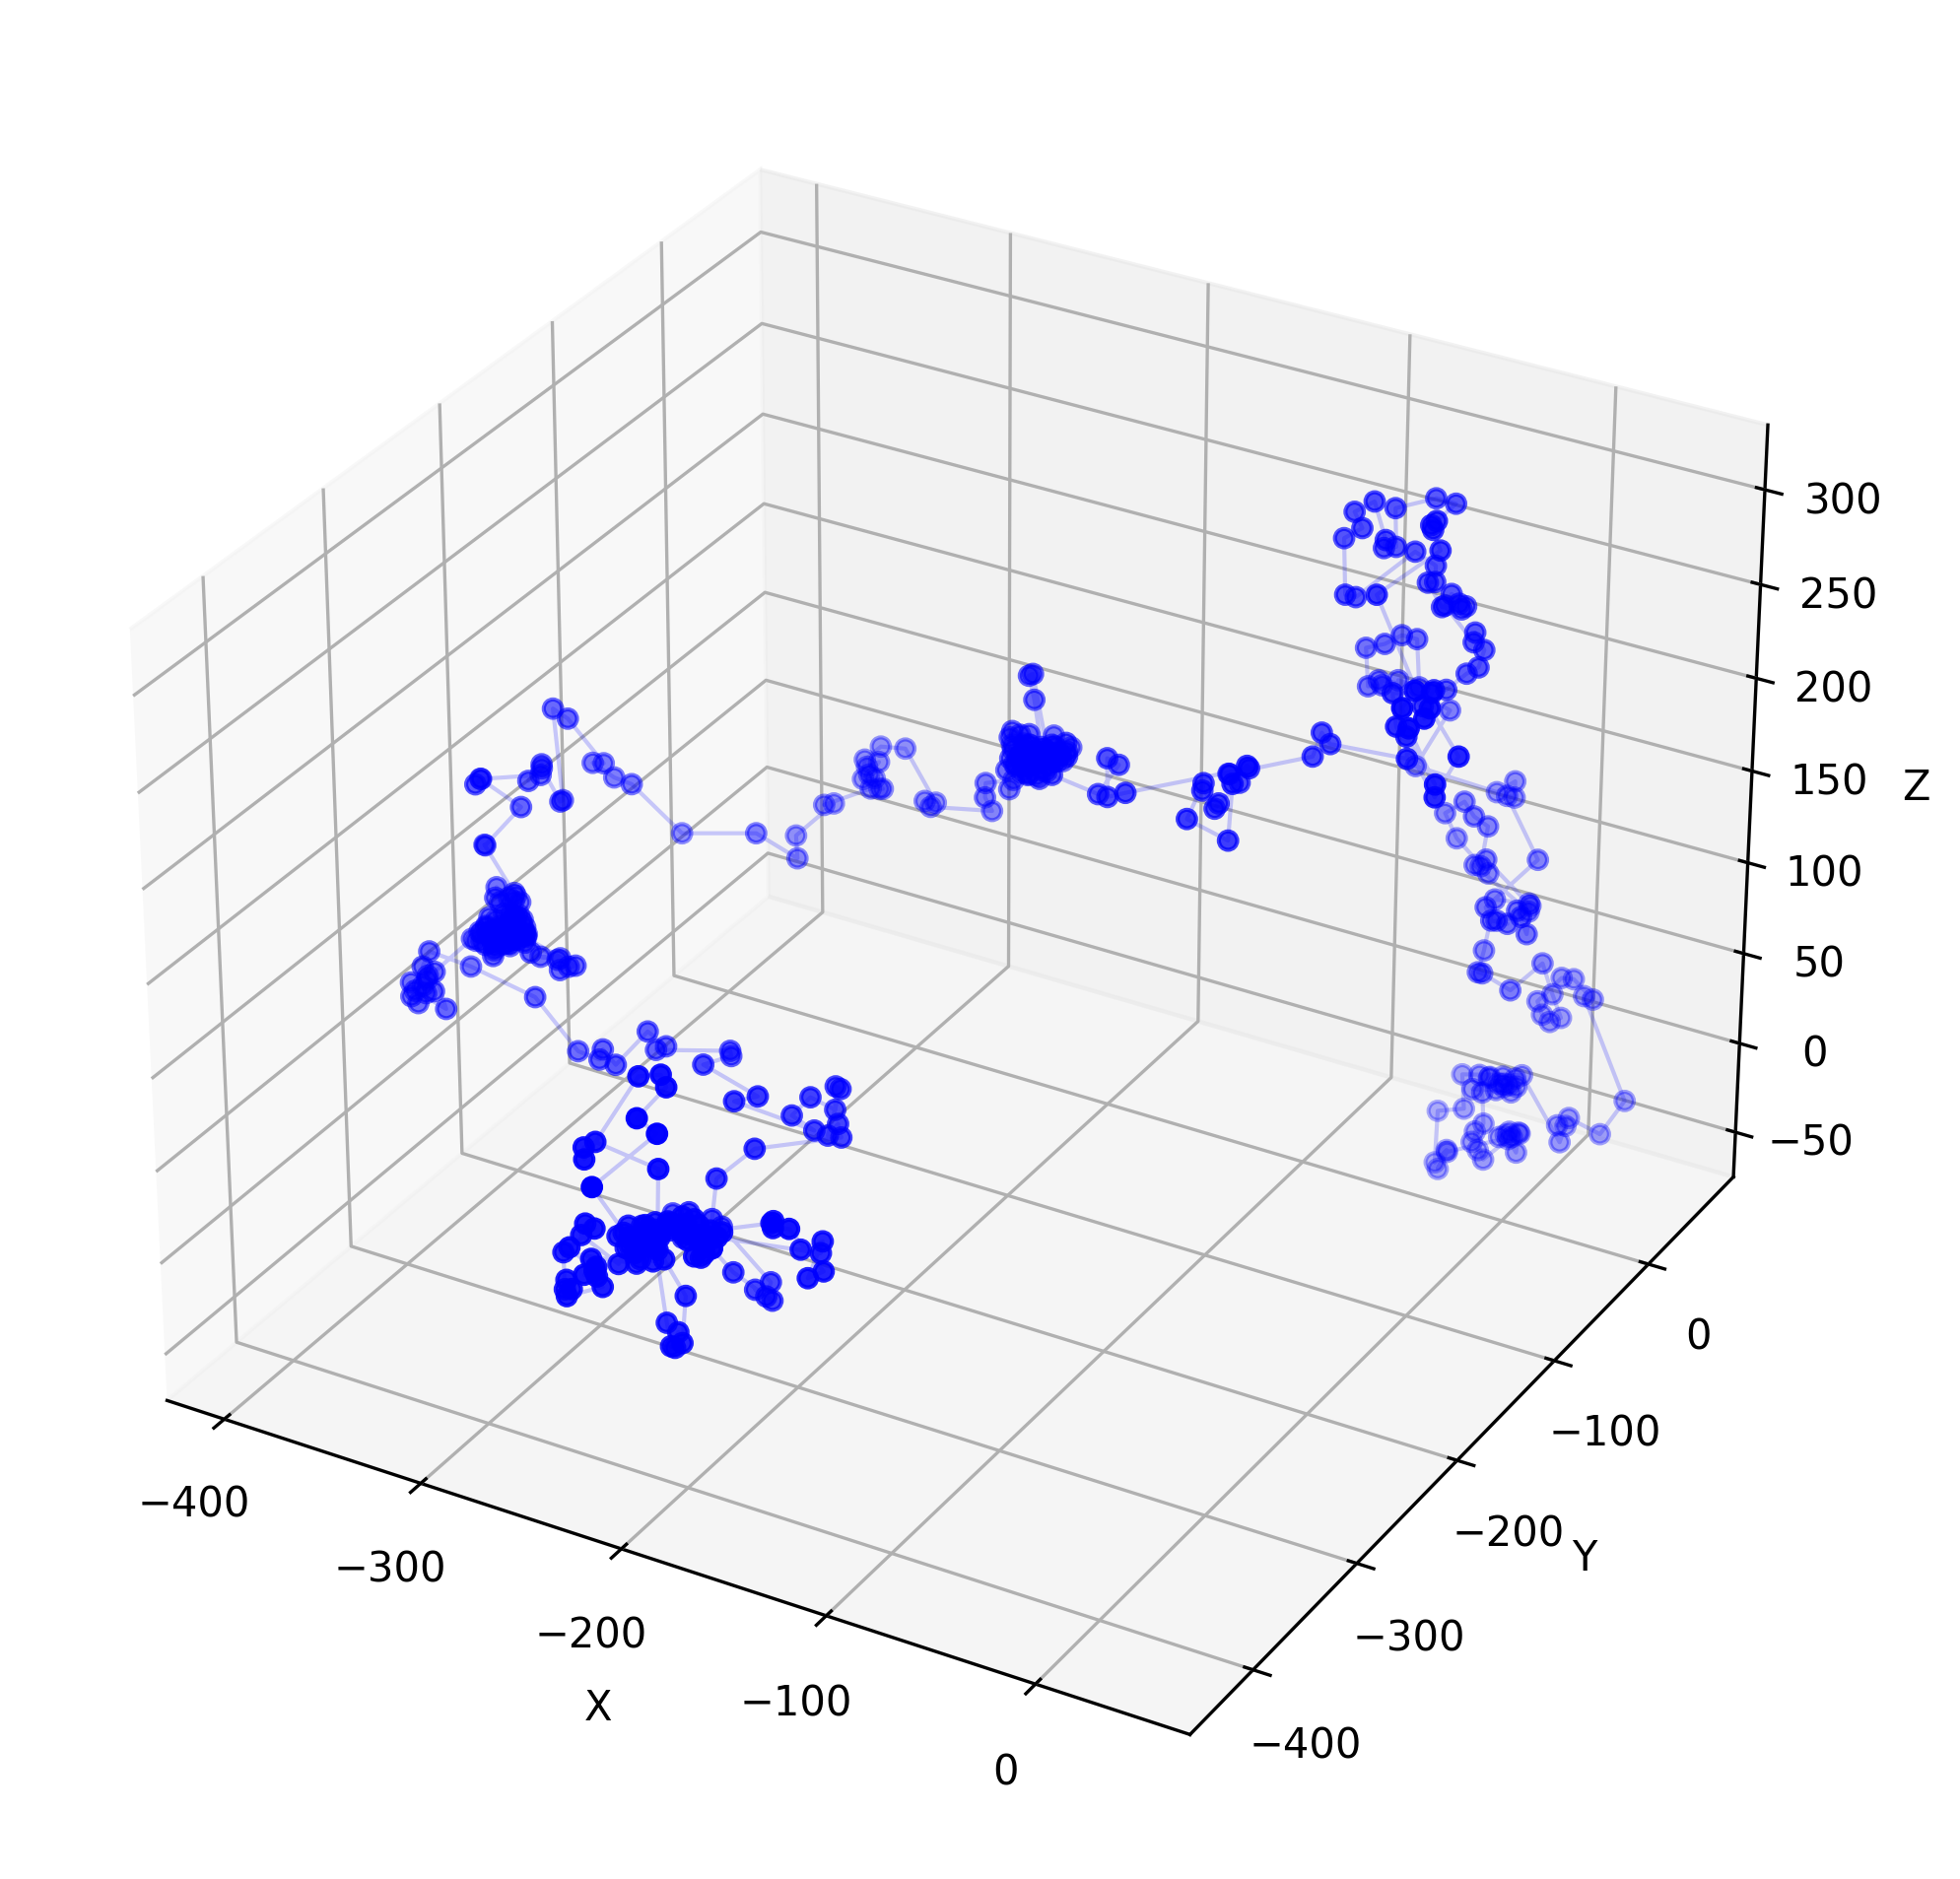

In [7]:
fig = plt.figure(figsize=(10,8), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_nucleo[:, 0], r_nucleo[:, 1], r_nucleo[:, 2], c='b', marker='o')
ax.plot(r_nucleo[:, 0], r_nucleo[:, 1], r_nucleo[:, 2], c='b', linestyle='-', linewidth=1, alpha = 0.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

#### Identify Clusters

We will define clusters as sets of sequential nucleosomes of more than a specified count whose linker lengths are all less than the interaction distance `a`.

In [8]:
# Specify a minumum cluster count (this is arbitrary)
min_count = 4

# Identify linker lengths within interaction distance
gamma = nuc_arr.gamma

# Group `gamma` into sets of equivalent values
adjacent_sets = groupby(gamma)

# Characterize the sets
set_types = {}
set_sizes = {}
bead_set_map = {}
set_bead_map = {}
index = 0
for i, (key, group) in enumerate(adjacent_sets):
    set_types[i] = key
    set_size = len(list(group))
    set_sizes[i] = set_size
    set_bead_map[i] = []
    for bead in range(index, index+set_size):
        bead_set_map[bead] = i
        set_bead_map[i].append(bead)
    index += set_size

# Identify clusters (sets of type `1` with size >= 4)
n_sets = len(list(set_types.keys()))
clusters = [
    i for i in range(n_sets)
    if (set_types[i] == 1) and (set_sizes[i] >= min_count)
]

# Identify nucleosomes in each cluster
cluster_inds = {cluster: set_bead_map[cluster] for cluster in clusters}
cluster_r = {cluster: r_nucleo[inds, :] for cluster, inds in cluster_inds.items()}

#### Calculate Radius of Gyration for Clusters

In [9]:
def radius_of_gyration(coordinates):
    """Calculate the radius of gyration for a set of coordinates.
    """
    center_of_mass = np.mean(coordinates, axis=0)
    displacement_vectors = coordinates - center_of_mass
    squared_distances = np.sum(displacement_vectors ** 2, axis=1)
    rg_squared = np.mean(squared_distances)
    rg = np.sqrt(rg_squared)
    return rg

In [10]:
# Calculate the radius of gyration for each cluster
cluster_Rg = {cluster: radius_of_gyration(coords) for cluster, coords in cluster_r.items()}

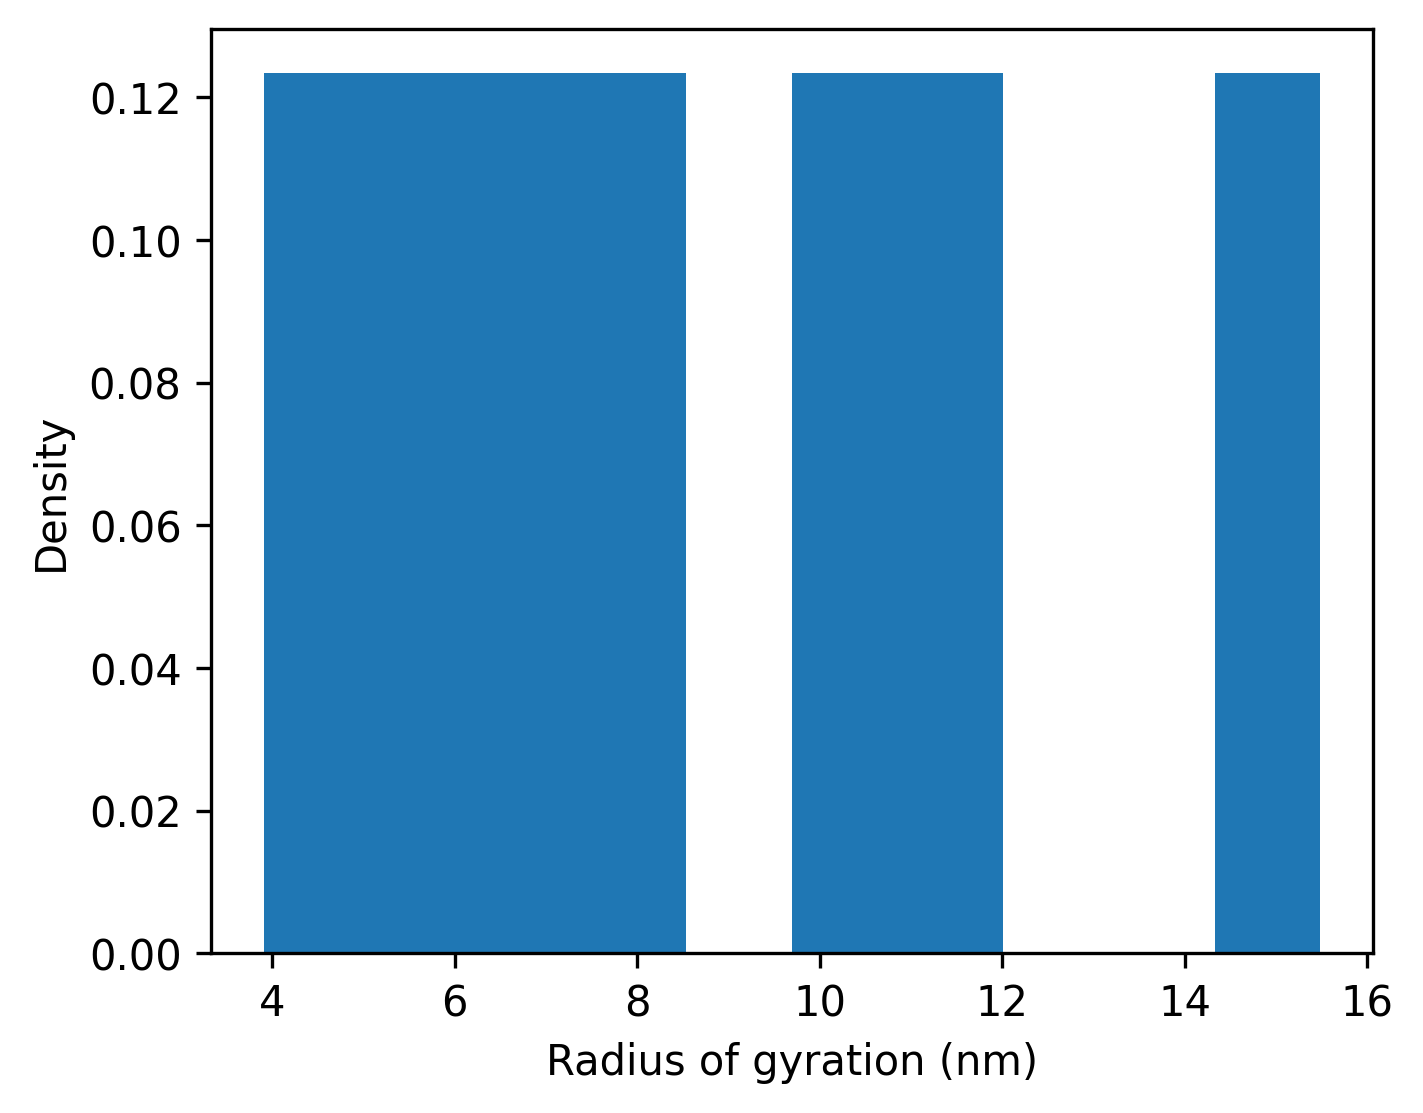

In [11]:
# Plot the distribution of radii of gyration
plt.figure(figsize=(5,4), dpi=300)
plt.hist(list(cluster_Rg.values()), density=True)
plt.xlabel("Radius of gyration (nm)")
plt.ylabel("Density")
plt.show()

#### Generate a Representative Distribution for Radius of Gyration

If we repeat cluster characterization for various realizations of the nucleosome array, we can generate a representative distribution for radius of gyration.

In [12]:
n_realizations = 20  # I should really run this for ~1000 realizations
Rg_all = []

for i in range(n_realizations):

    # Generate a configuration for the nucleosome array
    _, _, _, r_nucleo, _ = gen_chromo_conf(nuc_arr.linker_lengths)
    
    # Identify coordinates for each cluster
    cluster_r = {cluster: r_nucleo[inds, :] for cluster, inds in cluster_inds.items()}
    
    # Calculate the radius of gyration for each cluster
    cluster_Rg = {cluster: radius_of_gyration(coords) for cluster, coords in cluster_r.items()}
    
    # Store the radii of gyration
    Rg_all += list(cluster_Rg.values())

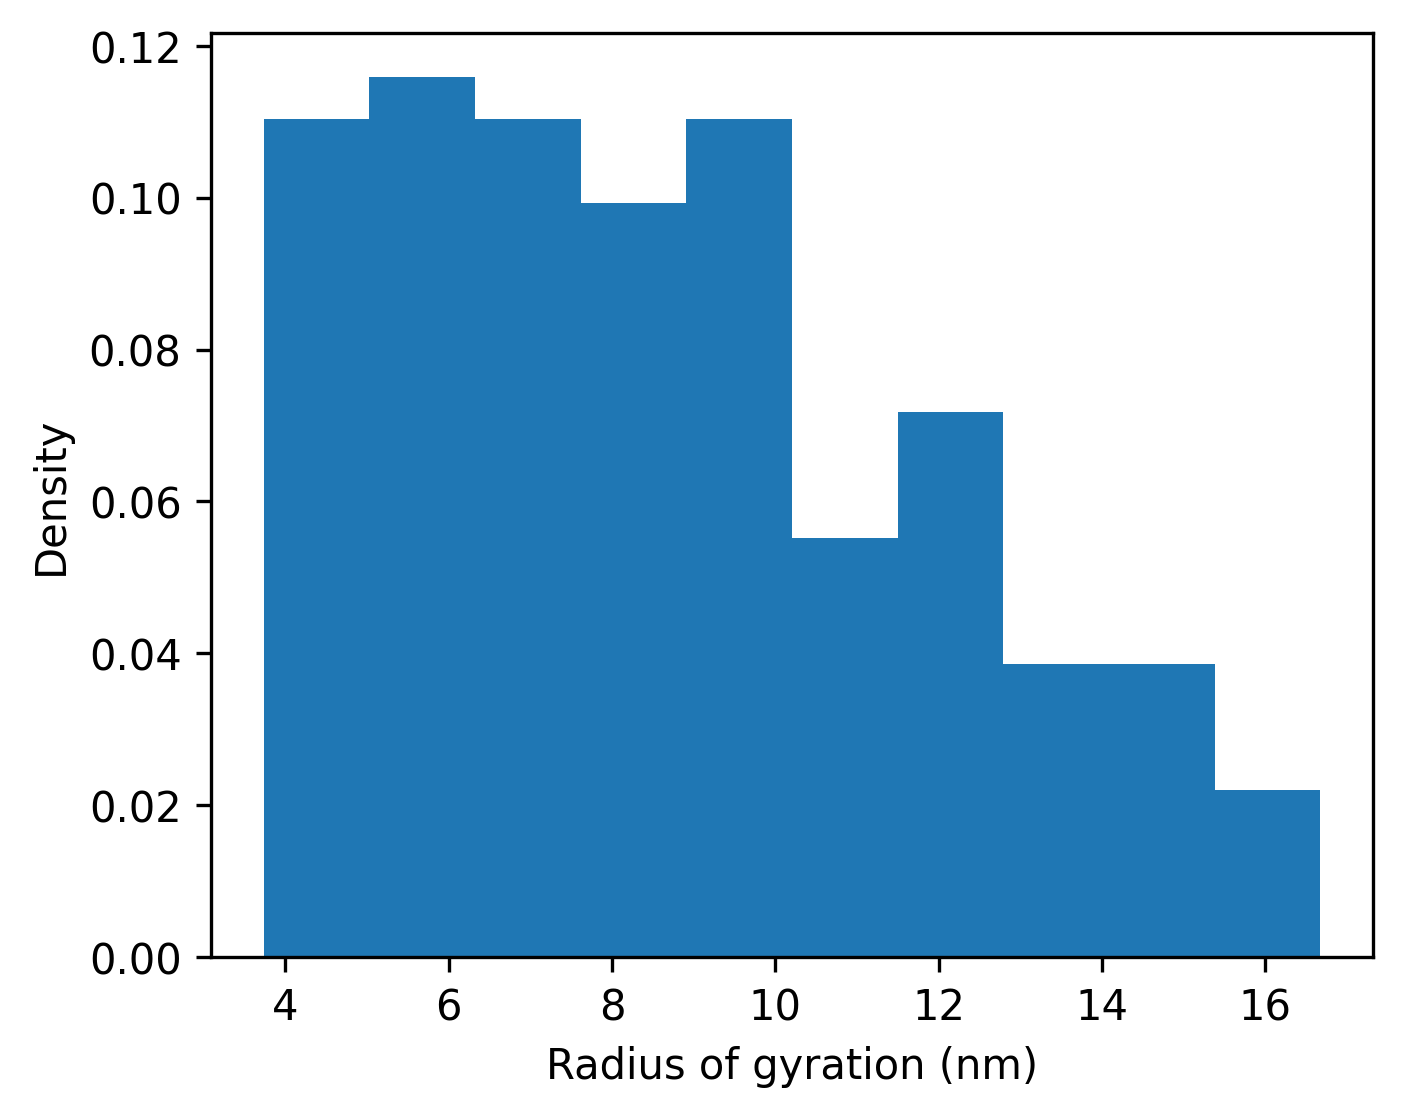

In [13]:
# Plot the distribution of radii of gyration for multiple realizations
plt.figure(figsize=(5,4), dpi=300)
plt.hist(Rg_all, density=True)
plt.xlabel("Radius of gyration (nm)")
plt.ylabel("Density")
plt.show()